In [12]:
# %pip show onnx
# use onnx < 1.15

In [13]:
# %pip install onnx==1.14.1 

In [14]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

import os
import tarfile
import pandas as pd
from tqdm import tqdm
from urllib.request import urlopen
from io import BytesIO

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import WavReader

from mltu.tensorflow.dataProvider import DataProvider
from mltu.transformers import LabelIndexer, LabelPadding, SpectrogramPadding
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

from model import train_model
from configs import ModelConfigs

In [15]:
import torch
torch.cuda.is_available()

True

In [16]:
dataset_path = "./dataset/"
metadata_path = "../dataset/metadata.csv"
wavs_path = dataset_path + "/Audio/"

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep=",", header=None)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]

In [17]:
metadata_df

,file_name,normalized_transcription
0,Female_1/1,"Waduh, agak pricey ya makanannya"
1,Female_1/10,"Wah, ini tempat hits paling culture yang perna..."
2,Female_1/11,"Besok pada free semua, kan?"
3,Female_1/12,Setelah kita dinner rencananya akan ada after-...
4,Female_1/13,"Eh, liat deh boneka teddy bear nya cute banget"
...,...,...
844,Male_9/95,Let's plan our next trip ke kota sebelah
845,Male_9/96,Jangan lupa mencoba local delicacies yang terk...
846,Male_9/97,Ayo pergi ke city center untuk shopping spree
847,Male_9/98,"Let's go ke beach resort ini, guys!"


In [18]:
dataset = [[f"../dataset/korpusVAD/Audio/{file}.wav", label.lower()] for file, label in metadata_df.values.tolist()]

In [19]:
dataset

[['../dataset/korpusVAD/Audio/Female_1/1.wav',
  'waduh, agak pricey ya makanannya'],
 ['../dataset/korpusVAD/Audio/Female_1/10.wav',
  'wah, ini tempat hits paling culture yang pernah aku kunjungi'],
 ['../dataset/korpusVAD/Audio/Female_1/11.wav', 'besok pada free semua, kan?'],
 ['../dataset/korpusVAD/Audio/Female_1/12.wav',
  'setelah kita dinner rencananya akan ada after-party'],
 ['../dataset/korpusVAD/Audio/Female_1/13.wav',
  'eh, liat deh boneka teddy bear nya cute banget'],
 ['../dataset/korpusVAD/Audio/Female_1/14.wav',
  'sebenernya dia tipikal cowok red flag'],
 ['../dataset/korpusVAD/Audio/Female_1/15.wav',
  'wah, glaze di cakenya enak banget'],
 ['../dataset/korpusVAD/Audio/Female_1/16.wav', 'next year mau ke europe?'],
 ['../dataset/korpusVAD/Audio/Female_1/17.wav',
  'menurut aku, ini tempat makan paling hidden gem'],
 ['../dataset/korpusVAD/Audio/Female_1/18.wav',
  'kamu takut naik roller-coaster?'],
 ['../dataset/korpusVAD/Audio/Female_1/19.wav',
  'semua makanan di

In [20]:
# import numpy as np
# wav_path = '../dataset/korpus/Audio/Male_9/97.wav'
# label =  'ayo ke historical landmarks di kota ini.'
# spectrogram = WavReader.get_spectrogram(wav_path, frame_length=configs.frame_length, frame_step=configs.frame_step, fft_length=configs.fft_length)
# WavReader.plot_raw_audio(wav_path, label)

# padded_spectrogram = np.pad(spectrogram, ((0, configs.max_spectrogram_length - spectrogram.shape[0]),(0,0)), mode="constant", constant_values=0)

# WavReader.plot_spectrogram(spectrogram, label)

In [21]:

# Create a ModelConfigs object to store model configurations
configs = ModelConfigs()

In [22]:
max_text_length, max_spectrogram_length = 0, 0
for file_path, label in tqdm(dataset):
    spectrogram = WavReader.get_spectrogram(file_path, frame_length=configs.frame_length, frame_step=configs.frame_step, fft_length=configs.fft_length)
    valid_label = [c for c in label if c in configs.vocab]
    max_text_length = max(max_text_length, len(valid_label))
    max_spectrogram_length = max(max_spectrogram_length, spectrogram.shape[0])
    configs.input_shape = [max_spectrogram_length, spectrogram.shape[1]]

configs.max_spectrogram_length = max_spectrogram_length
configs.max_text_length = max_text_length
configs.save()

 37%|███▋      | 315/849 [00:01<00:02, 190.92it/s]

In [ ]:
print(max_text_length, max_spectrogram_length )

131 1155


In [ ]:
# Create a data provider for the dataset
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[
        WavReader(frame_length=configs.frame_length, frame_step=configs.frame_step, fft_length=configs.fft_length),
        ],
    transformers=[
        SpectrogramPadding(max_spectrogram_length=configs.max_spectrogram_length, padding_value=0),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
)

In [ ]:

# Split the dataset into training and validation sets
train_data_provider, val_data_provider = data_provider.split(split = 0.8)


In [ ]:

# Creating TensorFlow model architecture
model = train_model(
    input_dim = configs.input_shape,
    output_dim = len(configs.vocab),
    dropout=0.5
)

# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate), 
    loss=CTCloss(), 
    metrics=[
        CERMetric(vocabulary=configs.vocab),
        WERMetric(vocabulary=configs.vocab)
        ],
    run_eagerly=False
)
model.summary(line_length=300)

Model: "model"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                                                                          Output Shape                                                                                                            Param #                                      
 input (InputLayer)                                                                                                                    [(None, 1155, 193)]                                                                                                     0                                            
                                                                                  

In [ ]:

# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.8, min_delta=1e-10, patience=5, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

# Train the model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
    workers=configs.train_workers,
    use_multiprocessing=True
)

# Save training and validation datasets as csv files
train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))


Epoch 1/4
28/28 [==============================] - ETA: 0s - loss: 555.5588 - CER: 1.2774 - WER: 1.1150 
Epoch 1: val_CER improved from inf to 0.94159, saving model to Models\202312022332\model.h5
28/28 [==============================] - 565s 20s/step - loss: 555.5588 - CER: 1.2774 - WER: 1.1150 - val_loss: 378.6385 - val_CER: 0.9416 - val_WER: 1.0000 - lr: 0.0010
Epoch 2/4


c:\Users\mahesa lizardy\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - ETA: 0s - loss: 404.8994 - CER: 0.8626 - WER: 1.0911 
Epoch 2: val_CER did not improve from 0.94159
28/28 [==============================] - 556s 20s/step - loss: 404.8994 - CER: 0.8626 - WER: 1.0911 - val_loss: 352.6902 - val_CER: 0.9798 - val_WER: 1.0000 - lr: 0.0010
Epoch 3/4
28/28 [==============================] - ETA: 0s - loss: 373.1178 - CER: 0.9122 - WER: 1.0052 
Epoch 3: val_CER did not improve from 0.94159
28/28 [==============================] - 561s 20s/step - loss: 373.1178 - CER: 0.9122 - WER: 1.0052 - val_loss: 313.3020 - val_CER: 0.9486 - val_WER: 0.9982 - lr: 0.0010
Epoch 4/4
28/28 [==============================] - ETA: 0s - loss: 341.3768 - CER: 0.8208 - WER: 1.1033 
Epoch 4: val_CER improved from 0.94159 to 0.91945, saving model to Models\202312022332\model.h5
28/28 [==============================] - 574s 20s/step - loss: 341.3768 - CER: 0.8208 - WER: 1.1033 - val_loss: 282.9995 - val_CER: 0.9195 - val_WER: 0.9994 - lr: 0.00

In [ ]:
import numpy as np

In [ ]:
import typing
import numpy as np

from mltu.inferenceModel import OnnxInferenceModel
from mltu.preprocessors import WavReader
from mltu.utils.text_utils import ctc_decoder, get_cer, get_wer

class WavToTextModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list

    def predict(self, data: np.ndarray):
        data_pred = np.expand_dims(data, axis=0)

        preds = self.model.run(None, {self.input_name: data_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]
        # argmax_preds = np.argmax(preds, axis=-1)
        return text


In [ ]:
# change path model
path_model = "Models/202312022332/"
if __name__ == "__main__":
    import pandas as pd
    from tqdm import tqdm
    from mltu.configs import BaseModelConfigs

    configs = BaseModelConfigs.load(path_model+"configs.yaml")

    model = WavToTextModel(model_path=configs.model_path, char_list=configs.vocab, force_cpu=False)

    df = pd.read_csv(path_model+"val.csv").values.tolist()

    accum_cer, accum_wer = [], []
    i=0
    for wav_path, label in tqdm(df):
        i+=1
        if (i==10):
            break
        spectrogram = WavReader.get_spectrogram(wav_path, frame_length=configs.frame_length, frame_step=configs.frame_step, fft_length=configs.fft_length)
        # WavReader.plot_raw_audio(wav_path, label)

        padded_spectrogram = np.pad(spectrogram, ((0, configs.max_spectrogram_length - spectrogram.shape[0]),(0,0)), mode="constant", constant_values=0)

        # WavReader.plot_spectrogram(spectrogram, label)

        text = model.predict(padded_spectrogram)

        true_label = "".join([l for l in label.lower() if l in configs.vocab])

        # cer = get_cer(text, true_label)
        # wer = get_wer(text, true_label)
        print(text)
        print(true_label)

        # accum_cer.append(cer)
        # accum_wer.append(wer)

    print(f"Average CER: {np.average(accum_cer)}, Average WER: {np.average(accum_wer)}")

  1%|          | 1/170 [00:00<00:27,  6.07it/s]

t ta
tempat itu kelihatan fancy banget


  1%|          | 2/170 [00:00<00:32,  5.11it/s]

ta
kita akan naik pesawat dari gate satu
t ta
menurut aku ini tempat makan paling hidden gem


  3%|▎         | 5/170 [00:00<00:29,  5.66it/s]

t a ta
batas checkout dari hotel ini jam berapa ya?
t ta
rekomendasi tourist spot mu sangatlah bagus


  4%|▎         | 6/170 [00:01<00:28,  5.72it/s]

t ta
beli tiket fast track aja biar gaperlu ngantri lama


  5%|▍         | 8/170 [00:01<00:29,  5.49it/s]

a ta
pengennya sih ke jurong tapi i don't mind kalo kamu mau ke tempat lain
t a ta
kita bisa coba activities water sports di pantai sini besok kayaknya asyik deh


  5%|▌         | 9/170 [00:01<00:29,  5.47it/s]

a ta
kalau ke pantai jangan lupa bawa sunscreen ya biar kulit kita tidak kena sun burn
Average CER: nan, Average WER: nan



c:\Users\mahesa lizardy\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\mahesa lizardy\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("Models/202312022332/model.h5")

ValueError: Unknown loss function: 'CTCloss'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
model.summary()

AttributeError: 'WavToTextModel' object has no attribute 'summary'

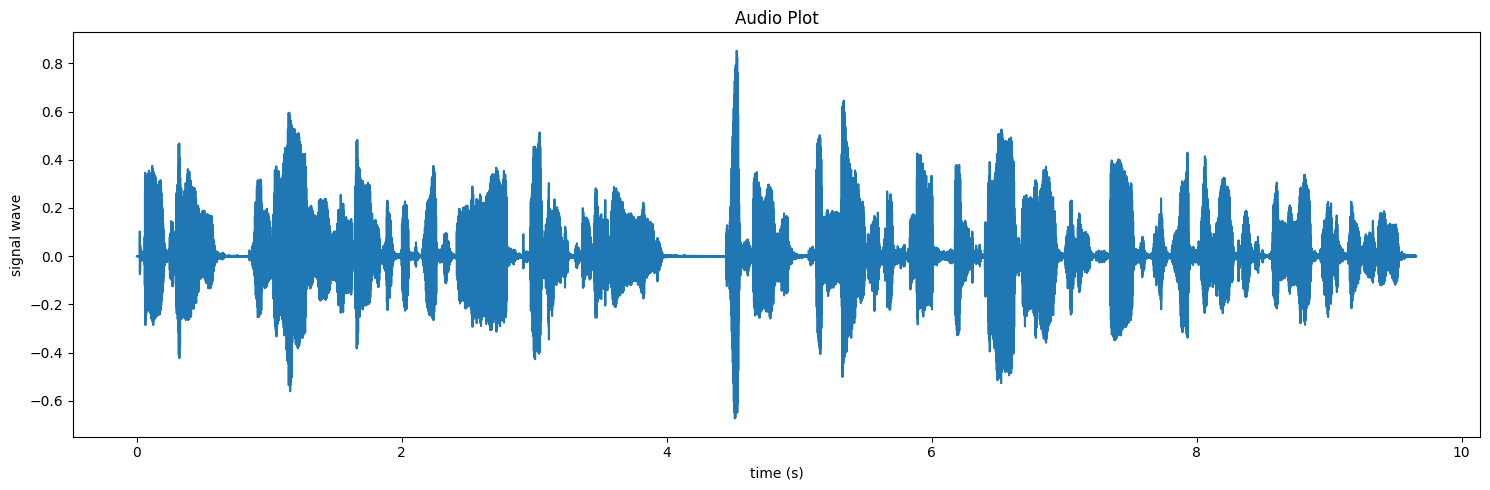

In [ ]:
spectrogram = WavReader.get_spectrogram('../dataset/LJ001-0001.wav', frame_length=configs.frame_length, frame_step=configs.frame_step, fft_length=configs.fft_length)
WavReader.plot_raw_audio('../dataset/LJ001-0001.wav', '')
